#### Контрольные вопросы (1 балл)

1. что такое порядок точности метода?

Ответ: это показатель, как быстро уменьшается погрешность аппроксимации при уменьшении шага $h$

$err(h) = C h^{p} + o(h^p)$, при $h \rightarrow 0$

2. какой порядок метода будет при численном дифференцировании по $N$ узлам и почему?

Ответ: $p = N-1$ для аппроксимации $f'(x_0)$ по N узлам.

При разложении в ряд Тейлора найдя веса, будет $N$ уравнений и $N$ неизвестных можно занулить все члены до порядка $h^{N-1}$

Первый незануленный будет идет за $m=N$ и погрешность $Ch^{N-1}$ 

3. как называется матрица СЛАУ на коэффициенты метода неопределенных коэффицентов? Существует ли единственное решение системы и почему?

Ответ: матрица Вандермонда по узлам $x_i$ относительно точки $x_0$

Единственность решения есть, если все узлы различны: $det A \neq 0$ у такой матрицы значит решение единственное

In [1]:
#скрипт, который реализует алгоритм метода неопределенных коэффициентов
import numpy as np
import numpy.linalg as la

def get_diff(u, l, m, h):
    n = u.size
    v = np.linspace(-l,m, n)
    # формируем матрицу системы в нужном виде
    A = np.fliplr(np.vander(v, v.size)).T 
    b = np.zeros(n)
    b[1] = 1
    alpha = la.solve(A,b)
    diff = 1/h*alpha.dot(u.T)
    return diff

p = 4 # порядок метода
a = np.pi/3
b = np.pi/2
h = (b-a)/p
print('h = ', h)
x = np.linspace(a, b, p+1)
u = np.sin(x) #ищем производную синуса

diff = get_diff(u, 0, p, h)
print('diff = ', diff)

h =  0.13089969389957473
diff =  0.4999823898925212


## Часть 1. Ошибка и обусловленность МНК (1 балл)

Задание:

1. написать скрипт, который строит график зависимости абсолютной ошибки от числа узлов. Используйте логарифмический масштаб, разумное число узлов. Обратите внимание, что сначала ошибка убывает, затем растет. Объясните почему.
2. Написать скрипт, который строит график зависимости числа обусловленности матрицы A системы с ростом ее размерности. Используйте логарифмический масштаб. Объясните поведение графика.

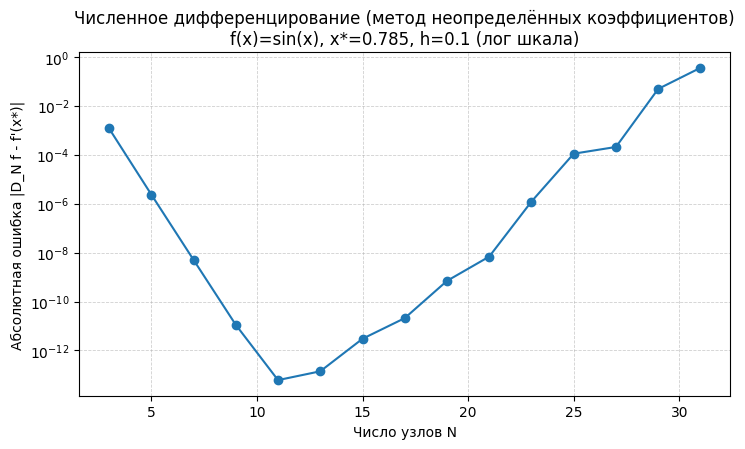

Почему кривая сначала падает, а потом растёт:
1) При росте N уменьшается аппроксимационная ошибка (учитывается больше моментов).
2) Но матрица моментов становится плохо обусловленной, веса растут по модулю,
   усиливаются ошибки округления. После некоторого N* начинается рост общей ошибки.


In [ ]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

def fd1(u_vals: np.ndarray, left: int, right: int, h: float) -> float:
    """
    Формула для f'(x0) методом неопределённых коэффициентов.
    """
    v = np.arange(-left, right + 1, dtype=float)
    n = v.size
    M = np.vander(v, N=n, increasing=True).T   # матрица моментов
    b = np.zeros(n); b[1] = 1.0
    w = la.solve(M, b)                          # веса
    return float(w @ u_vals) / h

# --- Пример ---
f  = np.sin          # функция
df = np.cos          # её точная производная
x0 = np.pi / 4       # точка
h  = 1e-1            # шаг
N_vals = list(range(3, 33, 2))  # число узлов (3,5,...,31)

# --- расчёт ошибок ---
true_val = df(x0)
errs = []

for N in N_vals:
    r = (N - 1) // 2                 # симметричный шаблон: left = right = r
    shifts = np.arange(-r, r + 1)
    x_nodes = x0 + shifts * h
    u = f(x_nodes)
    approx = fd1(u, r, r, h)
    errs.append(abs(approx - true_val))

errs = np.array(errs)

# --- график ---
plt.figure(figsize=(7.5, 4.6))
plt.semilogy(N_vals, errs, marker='o')
plt.xlabel('Число узлов N')
plt.ylabel("Абсолютная ошибка |D_N f - f'(x*)|")
plt.title('Численное дифференцирование (метод неопределённых коэффициентов)\n'
          f'f(x)=sin(x), x*={x0:.3f}, h={h:g} (лог шкала)')
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.6)
plt.tight_layout()
plt.show()

print("Почему кривая сначала падает, а потом растёт:")
print("1) При росте N уменьшается аппроксимационная ошибка (учитывается больше моментов).")
print("2) Но матрица становится плохо обусловленной, веса растут по модулю,")
print("   усиливаются ошибки округления. После некоторого N* начинается рост общей ошибки.")


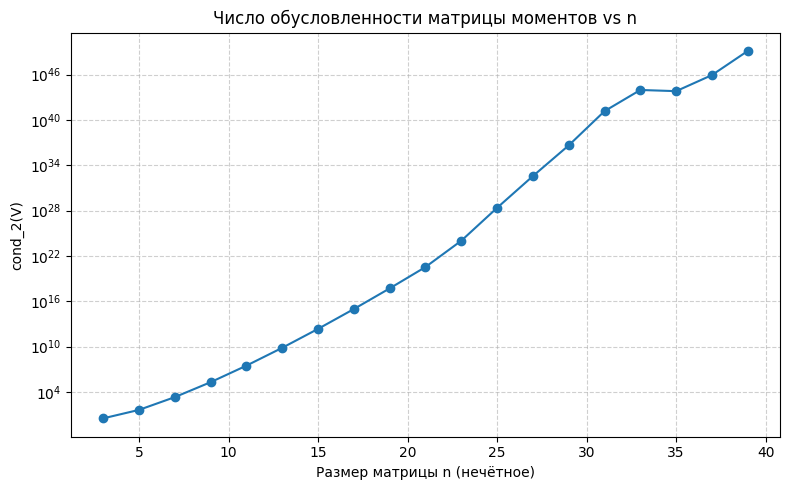

Почему cond растёт с n:
1) Столбцы [1, t, t^2, ...] становятся почти линейно зависимыми.
2) В матрице появляются числа сильно разных масштабов.
3) Поэтому малые округления сильно усиливаются -> cond быстро растёт.


In [34]:
# task 2: condition number of Vandermonde (по смещениям)

import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

def make_shifts(n_odd: int) -> np.ndarray:
    """Симметричные смещения: [-k, ..., 0, ..., k], n_odd = 2k+1 (должно быть нечётное)."""
    if n_odd % 2 == 0:
        raise ValueError("n_odd должно быть нечётным.")
    k = (n_odd - 1) // 2
    return np.arange(-k, k + 1, dtype=float)

def vandermonde_from_shifts(s: np.ndarray) -> np.ndarray:
    n = s.size
    return np.vstack([s**p for p in range(n)])


# диапазон размеров матрицы (нечётные): 3,5,7,...,39
sizes = list(range(3, 41, 2))
cond_vals = []

for n in sizes:
    t = make_shifts(n)
    V = vandermonde_from_shifts(t)
    cond_vals.append(la.cond(V, 2))

# график
plt.figure(figsize=(8, 5))
plt.semilogy(sizes, cond_vals, marker='o')
plt.xlabel("Размер матрицы n (нечётное)")
plt.ylabel("cond_2(V)")
plt.title("Число обусловленности матрицы моментов vs n")
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

print("Почему cond растёт с n:")
print("1) Столбцы [1, t, t^2, ...] становятся почти линейно зависимыми.")
print("2) В матрице появляются числа сильно разных масштабов.")
print("3) Поэтому малые округления сильно усиливаются -> cond быстро растёт.")


## Часть 2. Оценка порядка точности метода (2 балла)

Рассмотрим метод с порядком точности $p$. Тогда ошибка метода $\epsilon_h = Ch^p$, где $h$ - сеточный шаг. На сетке с двое меньшим шагом ошибка метода будет $\epsilon_{h/2} = C_1 \left(\frac{h}{2}\right)^p$. Если шаг h достаточно мелкий (ф-я меняется не очень сильно), то можно считать, что $C \approx C_1$. Тогда, исключив $C$ из первого равенства за счет второго, можно получить, что
$$
p = \log_2 \frac{\epsilon_h}{\epsilon_{h/2}}
$$

Задание:

3. написать скрипт, который численно будет определять порядок точности методов направленная разность и центральная разность. Построить график зависимости p от шага сетки в широком диапазоне значений h. На графике для h использовать логарифмический масштаб. Объяснить поведение графиков. Исследуйте при это области как слева, так и справа от плато. Почему положения плато отличаются для двух методов и находятся именно на своих уровнях (обосновать аналитически).

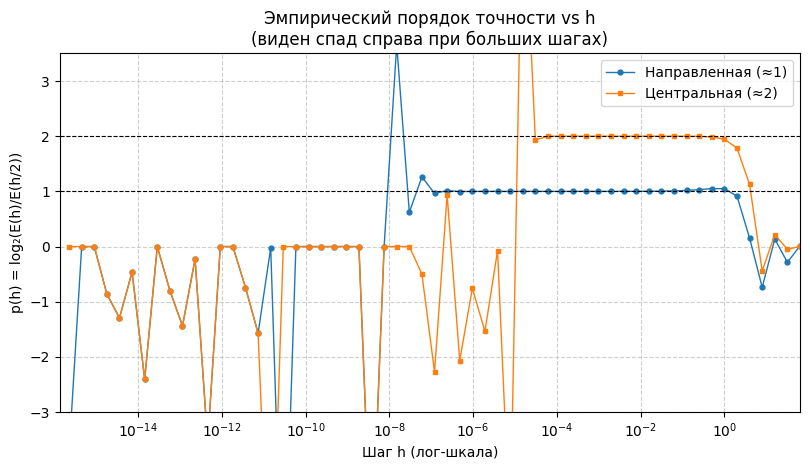

Как читать график:
+ Посередине — плато: p примерно 1 для направленной, p примерно 2 для центральной.
+ Справа (крупные h) аппроксимация грубая -> p(h) уходит вниз (видимый спад).
+ Слева (очень мелкие h) начинают доминировать округления -> разброс и падение.


In [42]:
import numpy as np
import matplotlib.pyplot as plt

# функция и точная производная
f, df = np.sin, np.cos
x0 = 1.0
true = df(x0)

def forward(fun, x, h):  # 1-й порядок
    return (fun(x + h) - fun(x)) / h

def central(fun, x, h):  # 2-й порядок
    return (fun(x + h) - fun(x - h)) / (2*h)

def ph(scheme, h):
    e1 = abs(scheme(f, x0, h)      - true)
    e2 = abs(scheme(f, x0, h / 2.) - true)
    return np.log2(e1 / e2) if e2 > 0 else np.nan

# --- берём большой  шаг, чтобы справа был спад ---
h0 = 64.0            # большой шаг -> увидим отклонение справа
K  = 60              # число делений пополам
hs = h0 / (2.0 ** np.arange(K))  # / 2^ сетка

p_f = np.array([ph(forward, h) for h in hs])
p_c = np.array([ph(central, h) for h in hs])

plt.figure(figsize=(8.2, 4.8))
plt.semilogx(hs[:-1], p_f[:-1], 'o-', ms=3.5, lw=1, label='Направленная (≈1)')
plt.semilogx(hs[:-1], p_c[:-1], 's-', ms=3.5, lw=1, label='Центральная (≈2)')

# линии «идеального» порядка
plt.axhline(1, color='k', ls='--', lw=0.8)
plt.axhline(2, color='k', ls='--', lw=0.8)

plt.xlabel('Шаг h (лог-шкала)')
plt.ylabel('p(h) = log₂(E(h)/E(h/2))')
plt.title('Эмпирический порядок точности vs h\n(виден спад справа при больших шагах)')
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.legend()

# расширение правую часть, чтобы спад был нагляднее
plt.xlim(min(hs)*1.2, h0)     # показываем весь правый край
plt.ylim(-3, 3.5)             # удобные пределы по y

plt.tight_layout()
plt.show()

print("Как читать график:")
print("+ Посередине — плато: p примерно 1 для направленной, p примерно 2 для центральной.")
print("+ Справа (крупные h) аппроксимация грубая -> p(h) уходит вниз (видимый спад).")
print("+ Слева (очень мелкие h) начинают доминировать округления -> разброс и падение.")


## Часть $3$. Дифференцирование с использованием полиномиальной интерполяции (2 балла)

Предложите вариант решения задачи численного дифференцирования на основании метода полиномиальной интерполяции по известным значениям функции. Реализуйте алгоритм, сравните его с МНК. Что общего у методов?

Короткий вывод:
- Оба метода: берём полиином $p(x)$ по точкам и считаем $p'(x0)$. Это по сути линейная комбинация значений $f(x_i)$,
  т.е. метод неопределённых коэффициентов.
- Интерполяция ($deg=N-1$) даёт высокий порядок, но чувствительна к шуму/округлению.
- МНК ($deg < N-1$) сглаживает и устойчивее к шуму, но формально имеет меньший порядок аппроксимации.


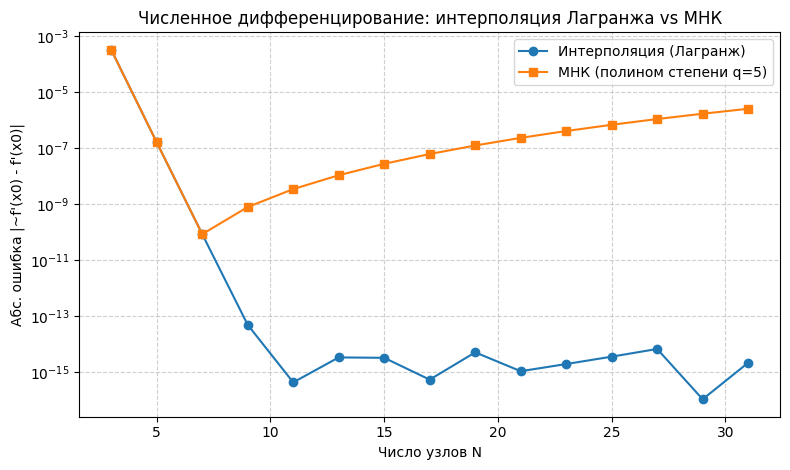

Выводы:
+ Интерполяция Лагранжа: f'(x0) = summ( f(x_i) * L'_i(0) / h), где L_i(t) — базисные многочлены.
+ МНК: аппроксимируем полиномом степени q и берём производную в центре.
+ При N = q+1 методы эквивалентны (интерполяция = частный случай МНК).
+ Интерполяция имеет более высокий порядок, но менее устойчива при большом N (из за матрицы Вандермонда).
+ МНК более стабильна и сглаживает ошибки при избытке узлов.


In [43]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

# --- 1) Производная через интерполяцию (в явной форме Лагранжа) ---
def get_diff_lagrange(u, l, m, h):
    """
    Вычисляет f'(x0) ≈ (1/h) * summ( f(x0 + t_j h) * L'_j(0)),
    где L_j(t) — базисные многочлены Лагранжа, построенные по узлам t_j.
    """
    n = u.size
    t = np.linspace(-l, m, n)  # узлы t_j
    Lp = np.zeros(n)           # сюда сохраним L'_j(0)

    for j in range(n):
        s = 0.0
        # производная базисного многочлена L_j в точке 0
        for k in range(n):
            if k == j:
                continue
            term = 1.0 / (t[j] - t[k])
            for i in range(n):
                if i == j or i == k:
                    continue
                term *= (0 - t[i]) / (t[j] - t[i])  # подставляем t=0
            s += term
        Lp[j] = s

    # формула для производной в x0
    return float(np.dot(u, Lp)) / h


# --- 2) Производная через МНК-полином степени q ---
def lsq_diff(u, l, m, h, q):
    t = np.linspace(-l, m, u.size)
    Phi = np.vander(t, N=q+1, increasing=True)
    a, *_ = la.lstsq(Phi, u, rcond=None)
    return float(a[1]) / h  # производная в 0 равна a1 -> делим на h


# --- тестовая задача ---
f, df = np.sin, np.cos
x0 = 0.7
h  = 0.05
q  = 5

Ns = list(range(3, 33, 2))   # 3,5,...,31
true = df(x0)

err_interp = []
err_lsq    = []

for N in Ns:
    r = (N - 1) // 2
    t = np.linspace(-r, r, N)
    x = x0 + t * h
    u = f(x)

    d_interp = get_diff_lagrange(u, r, r, h)
    d_lsq    = lsq_diff(u, r, r, h, q=min(q, N-1))

    err_interp.append(abs(d_interp - true))
    err_lsq.append(abs(d_lsq    - true))

err_interp = np.array(err_interp)
err_lsq    = np.array(err_lsq)

# --- график ---
plt.figure(figsize=(8, 4.8))
plt.semilogy(Ns, err_interp, 'o-', label='Интерполяция (Лагранж)')
plt.semilogy(Ns, err_lsq,    's-', label=f'МНК (полином степени q={q})')
plt.xlabel('Число узлов N')
plt.ylabel("Абс. ошибка |~f'(x0) - f'(x0)|")
plt.title('Численное дифференцирование: интерполяция Лагранжа vs МНК')
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# --- краткие выводы ---
print("Выводы:")
print("+ Интерполяция Лагранжа: f'(x0) = summ( f(x_i) * L'_i(0) / h), где L_i(t) — базисные многочлены.")
print("+ МНК: аппроксимируем полиномом степени q и берём производную в центре.")
print("+ При N = q+1 методы эквивалентны (интерполяция = частный случай МНК).")
print("+ Интерполяция имеет более высокий порядок, но менее устойчива при большом N (из за матрицы Вандермонда).")
print("+ МНК более стабильна и сглаживает ошибки при избытке узлов.")



Оба строят полином
Оба сводятся к линейной алгебре на одном и том же базисе [1,t,t2,…].

## Часть 4. Пример проблемы использования метода Гаусса для решения СЛАУ (2 балл)

Перед вами простая реализация метода Гаусса для решения СЛАУ. Далее по коду представлены две СЛАУ $A_1x = b_1$ и $A_2x = b_2$, эквивалентные с точностью до перестановки строк. ЗАДАНИЕ: необходимо объяснить, почему для представленного метода Гаусса решения различаются.

Ответ:

Почему решения разные:

- В A1 первым ведущим элементом берётся $~1 \cdot 10^{−16}$. Деление на ведущий элемент делает коэффициенты огромными -> большое накопление ошибок округления.

- В A2 строки переставлены, ведущий элемент = 2 — шаги стабильнее.

Метод Гаусса без выбора главного элемента не инвариантен к перестановке строк. Правильно решать систему $PAx=Pb$ с частичным выбором (перестановки строк), тогда оба варианта дадут одинаковый $x$.

In [44]:
import numpy as np
import copy 

def gauss( A_in, b_in ):
    n = b_in.size
    A = copy.deepcopy(A_in)
    b = copy.deepcopy(b_in)
    for k in range(0,n-1):
        for i in range(k+1,n):
            if A[i,k]!=0:
                c = A[i,k]/A[k,k]
                A[i,k+1:n] = A[i,k+1:n] - c*A[k,k+1:n]
                b[i] = b[i] - c*b[k]
                
    # обратный ход
    for k in range(n-1,-1,-1):
        b[k] = (b[k] - np.dot(A[k,k+1:n],b[k+1:n]))/A[k,k]
    return b

In [45]:
A1 = np.array([[1e-16, 1., -1.], 
               [-1., 2., -1.], 
               [2., -1., 0.]])

b1 = np.array([0., 0., 1.])

A2 = np.array([[2., -1., 0.], 
               [-1., 2., -1.], 
               [1e-16, 1., -1.]])

b2 = np.array([1., 0., 0.])

print('u1 = ', gauss(A1, b1))
print('u2 = ', gauss(A2, b2))

u1 =  [0.55511151 0.25       0.25      ]
u2 =  [1. 1. 1.]


Модифицировать метод Гаусса так, чтобы система $A_1x = b_1$ решалась корректно. ВАЖНО: реализация метода должна быть получена путем модификации метода gauss, а не переписыванием кода с нуля! 

In [46]:

import numpy as np
import copy

def gauss(A_in, b_in):
    n = b_in.size
    A = copy.deepcopy(A_in).astype(float)
    b = copy.deepcopy(b_in).astype(float)

    # прямой ход
    for k in range(0, n-1):
        piv = k + np.argmax(np.abs(A[k:, k]))
        if piv != k:
            # перестановка строк A и соответствующих элементов b
            A[[k, piv], :] = A[[piv, k], :]
            b[[k, piv]] = b[[piv, k]]

        for i in range(k+1, n):
            if A[i, k] != 0.0:
                c = A[i, k] / A[k, k]
                A[i, k+1:n] = A[i, k+1:n] - c * A[k, k+1:n]
                b[i] = b[i] - c * b[k]
        A[k+1:, k] = 0.0

    # обратный ход
    for k in range(n-1, -1, -1):
        b[k] = (b[k] - np.dot(A[k, k+1:n], b[k+1:n])) / A[k, k]
    return b

A1 = np.array([[1e-16, 1., -1.], 
               [-1., 2., -1.], 
               [2., -1., 0.]])

b1 = np.array([0., 0., 1.])

A2 = np.array([[2., -1., 0.], 
               [-1., 2., -1.], 
               [1e-16, 1., -1.]])

b2 = np.array([1., 0., 0.])

print('u1 = ', gauss(A1, b1))
print('u2 = ', gauss(A2, b2))

u1 =  [1. 1. 1.]
u2 =  [1. 1. 1.]


## Часть 5. LU разложение (1 балл)

Задание: 

реализовать алгоритм решения предыдущей задачи с матрицей A2 с помощью LU-разложение В решении должна выводиться L, U и собственно решение системы. 

ВАЖНО: реализация метода LU должна быть получена путем небольшой модификации метода gauss!  При это саму реализацию можно разделить на два метода: один метод собственно находит LU разложение (можно сделать переделкой цикла для матрицы A метода gauss), второй метод - непосредственное решение системы с помощью прямого и обратного хода. Ни в каком виде нельзя пользоваться пакетными методами (в частности, la.solve)

In [47]:
import numpy as np
import copy

def lu_factor_from_gauss(A_in):
    A = copy.deepcopy(A_in).astype(float)
    n = A.shape[0]
    L = np.eye(n, dtype=float)
    U = A.copy()

    for k in range(n-1):
        for i in range(k+1, n):
            m = U[i, k] / U[k, k]   # тот же множитель, что и в Гауссе
            L[i, k] = m             # сохраняем в L
            U[i, k:] -= m * U[k, k:] 
            U[i, k] = 0.0
    return L, U

def forward_substitution(L, b):
    n = len(b)
    y = np.zeros(n, float)
    for i in range(n):
        y[i] = b[i] - np.dot(L[i, :i], y[:i])
    return y

def back_substitution(U, y):
    n = len(y)
    x = np.zeros(n, float)
    for i in range(n-1, -1, -1):
        x[i] = (y[i] - np.dot(U[i, i+1:], x[i+1:])) / U[i, i]
    return x

# Данные из предыдущей задачи
A2 = np.array([[ 2., -1.,  0.],
               [-1.,  2., -1.],
               [1e-16, 1., -1.]], dtype=float)
b2 = np.array([1., 0., 0.], dtype=float)

# Разложение и решение
L, U = lu_factor_from_gauss(A2)
y = forward_substitution(L, b2)
x = back_substitution(U, y)

print("L =\n", L)
print("U =\n", U)
print("x =", x)

L =
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.00000000e-01  1.00000000e+00  0.00000000e+00]
 [ 5.00000000e-17  6.66666667e-01  1.00000000e+00]]
U =
 [[ 2.         -1.          0.        ]
 [ 0.          1.5        -1.        ]
 [ 0.          0.         -0.33333333]]
x = [1. 1. 1.]


## Часть 6. Нахождение обратной матрицы с помощью LU разложения (1 балл)

Задание:

Предложить алгоритм с использованием LU-разложения и найти обратную матрицу с точностью $\epsilon = 10^{-3}$:
$$
A = \begin{pmatrix} 
1 & 1  & 1 \\
0 & 1 & 2 \\
7 & 1 & 4 \\
\end{pmatrix}
$$
Для необходимых оценок использовать первую норму. Сравнить результат со значением, найденным с помощью функции numpy.linalg.inv.

In [48]:

import numpy as np

def lu_pp(A):
    A = A.astype(float).copy()
    n = A.shape[0]
    U = A.copy()
    L = np.eye(n)
    P = np.eye(n)

    for k in range(n-1):
        piv = k + np.argmax(np.abs(U[k:, k]))
        if piv != k:
            U[[k, piv], :] = U[[piv, k], :]
            P[[k, piv], :] = P[[piv, k], :]
            if k > 0:
                L[[k, piv], :k] = L[[piv, k], :k]
        for i in range(k+1, n):
            m = U[i, k] / U[k, k]
            L[i, k] = m
            U[i, k:] -= m * U[k, k:]
            U[i, k] = 0.0
    return P, L, U

def forward_subst(L, b):
    n = len(b)
    y = np.zeros(n)
    for i in range(n):
        y[i] = b[i] - np.dot(L[i, :i], y[:i])
    return y

def back_subst(U, y):
    n = len(y)
    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        x[i] = (y[i] - np.dot(U[i, i+1:], x[i+1:])) / U[i, i]
    return x

def inv_by_lu(A):
    n = A.shape[0]
    P, L, U = lu_pp(A)
    E = np.eye(n)
    Ainv = np.zeros_like(A, dtype=float)
    # решаем A X = I по столбцам X
    for k in range(n):
        rhs = P @ E[:, k]
        y = forward_subst(L, rhs)
        x = back_subst(U, y)
        Ainv[:, k] = x
    return Ainv

# Матрица из задания
A = np.array([[1., 1., 1.],
              [0., 1., 2.],
              [7., 1., 4.]])

A_inv_my = inv_by_lu(A)
A_inv_np = np.linalg.inv(A)

# Проверки и оценка в первой норме
norm1 = lambda M: np.linalg.norm(M, 1)

eps_req = 1e-3
err1 = norm1(A_inv_my - A_inv_np)
residual1 = norm1(A @ A_inv_my - np.eye(A.shape[0]))

print("A^{-1} (через LU):\n", A_inv_my)
print("\nA^{-1} (numpy):\n", A_inv_np)
print("\nA^{-1}_LU - A^{-1}_numpy =", err1)
print("A·A^{-1}_LU - I =", residual1)
print("Требуемая точность ε =", eps_req)

A^{-1} (через LU):
 [[ 0.22222222 -0.33333333  0.11111111]
 [ 1.55555556 -0.33333333 -0.22222222]
 [-0.77777778  0.66666667  0.11111111]]

A^{-1} (numpy):
 [[ 0.22222222 -0.33333333  0.11111111]
 [ 1.55555556 -0.33333333 -0.22222222]
 [-0.77777778  0.66666667  0.11111111]]

A^{-1}_LU - A^{-1}_numpy = 7.771561172376096e-16
A·A^{-1}_LU - I = 5.551115123125783e-16
Требуемая точность ε = 0.001
